In [26]:
import os

In [27]:
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/restaurants'
restaurants = os.listdir(img_dir)
restaurants

['images-5.jpeg', 'images-2.jpeg', 'images-3.jpeg', 'images-4.jpeg']

## 1. keras-ocr

In [28]:
import matplotlib.pyplot as plt
import keras_ocr

In [29]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
# 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러온다.
pipeline = keras_ocr.pipeline.Pipeline()

images = [keras_ocr.tools.read(os.path.join(img_dir, restaurant)) for restaurant in restaurants]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, restaurant)]) for restaurant in restaurants]

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


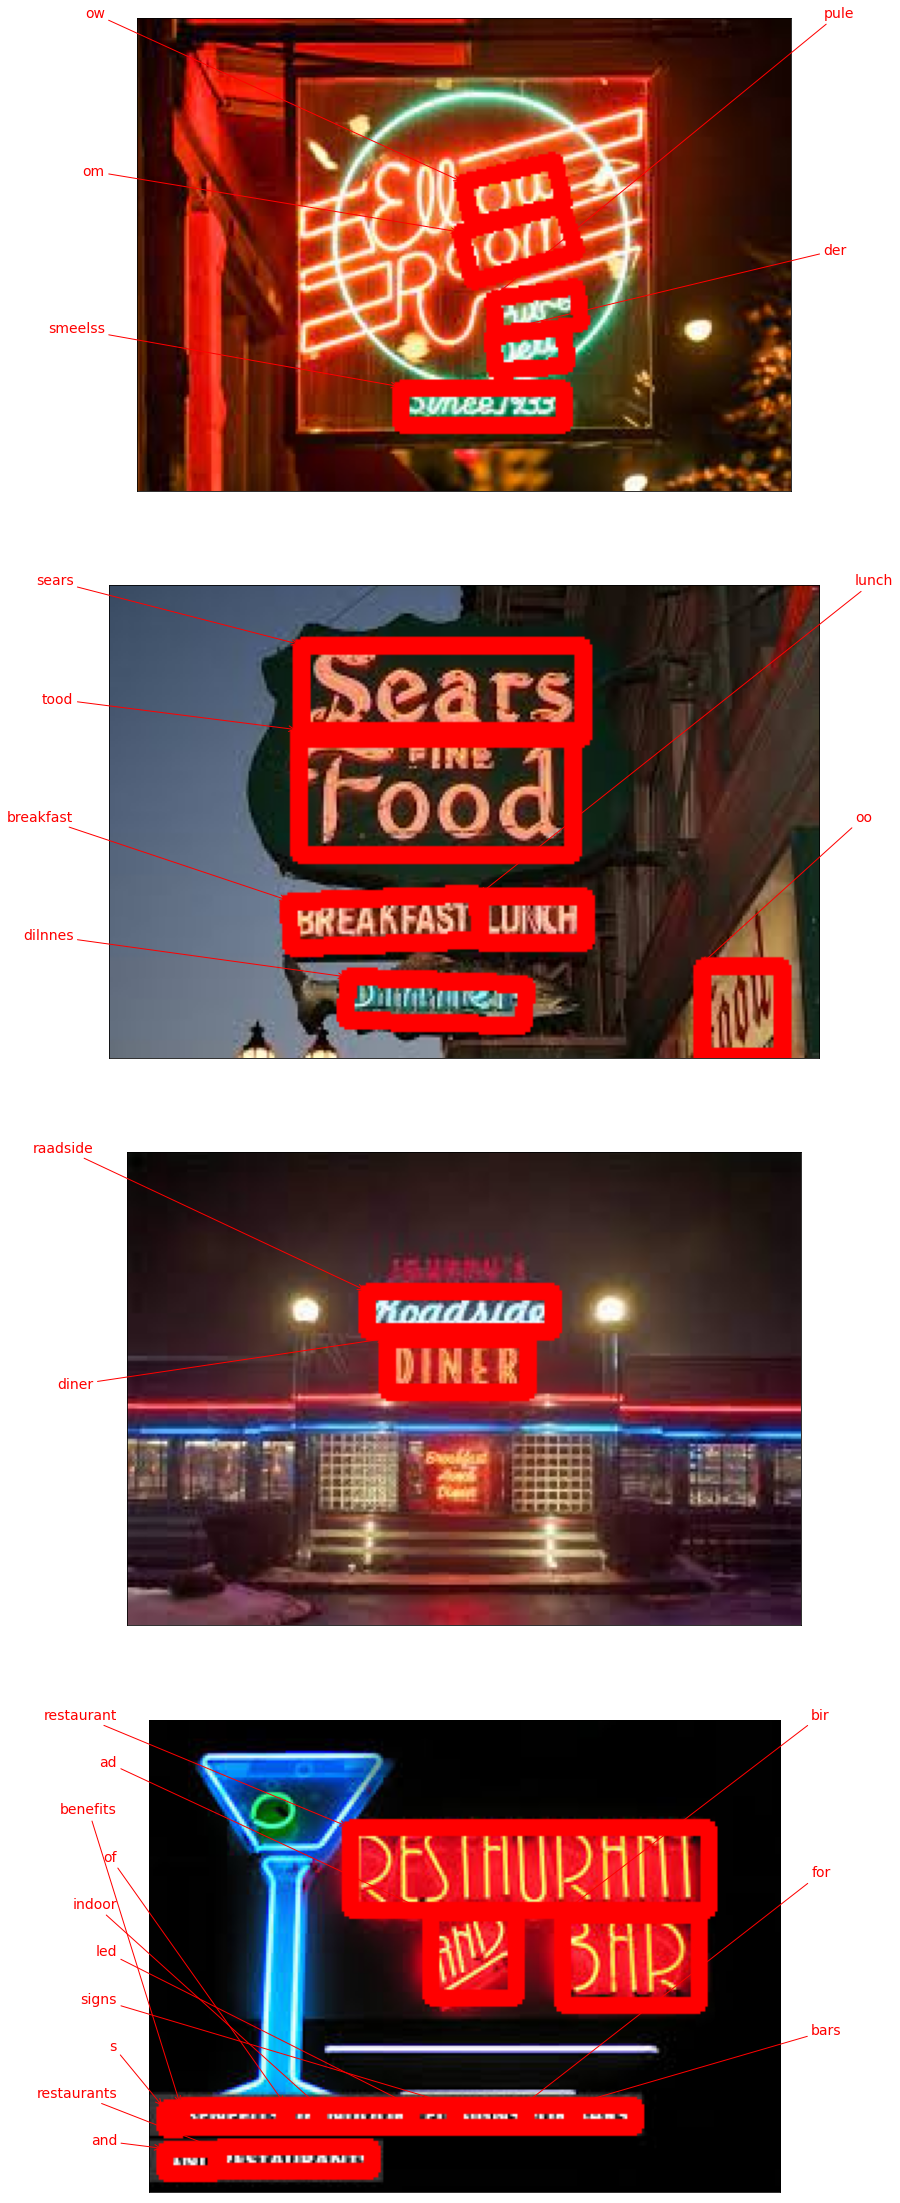

In [30]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(40, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 2. tesseract OCR

In [39]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [40]:
def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [46]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/restaurants/'

for restaurant in restaurants:
    print(f'[{restaurant}]')
    try:
        recognize_images(os.path.join(img_dir, restaurant), save_dir)
    except:
        print(f'Cannot recognize characters from {restaurant}')

[images-5.jpeg]

Done
[images-2.jpeg]
rir


“Food

CaS

iG

Done
[images-3.jpeg]

Done
[images-4.jpeg]
{™ y

Done


## 3. 구글 OCR

In [62]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

# Step3. 테스트 결과 정리

- 비교하는 함수 만들어주기

In [52]:
def compare_ocr(restaurant):
    print('[keras-ocr]')
    idx = restaurants.index(restaurant)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('[Tesseract]')
    recognize_images(os.path.join(img_dir, restaurant), save_dir)

[keras-ocr]


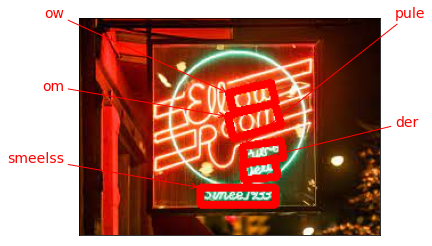

[Tesseract]

Done


In [53]:
compare_ocr('images-5.jpeg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


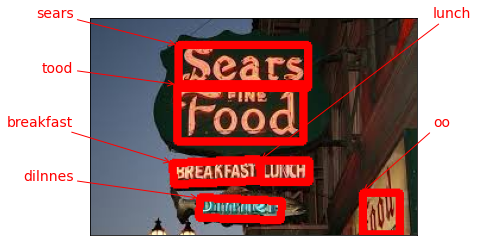

[Tesseract]
rir


“Food

CaS

iG

Done


In [54]:
compare_ocr('images-2.jpeg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


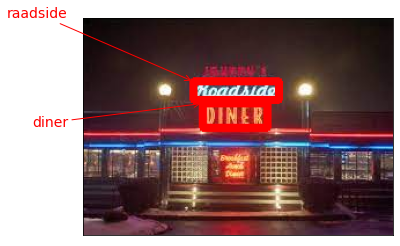

[Tesseract]

Done


In [55]:
compare_ocr('images-3.jpeg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


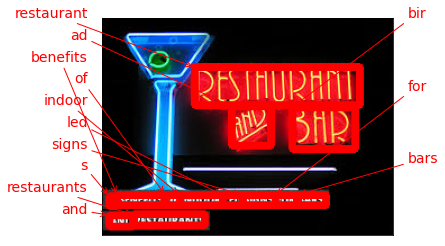

[Tesseract]
{™ y

Done


In [56]:
compare_ocr('images-4.jpeg')

# Step4. 결과 분석과 회고


- 일단 tesseract는 사용하기 어려울것 같다. 정확도가 매우 낮다.

- 케라스는 글자들이 촘촘히 붙어있는 문장들도 인식을 잘하는것 보니 신기하다.. 이게..무료라고?
    
- Google OCR API 가입안됨. 시간은 돈으로 사는 것이다.

- keras-ocr로 사용하는게 나을 것 같다.

- - 영문 필기체는 못알아봄